In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

class LSTM(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LSTM, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.Wf = self.add_weight(shape=(input_shape[-1] + self.units, self.units), initializer='glorot_uniform', name='Wf')
        self.Wi = self.add_weight(shape=(input_shape[-1] + self.units, self.units), initializer='glorot_uniform', name='Wi')
        self.Wc = self.add_weight(shape=(input_shape[-1] + self.units, self.units), initializer='glorot_uniform', name='Wc')
        self.Wo = self.add_weight(shape=(input_shape[-1] + self.units, self.units), initializer='glorot_uniform', name='Wo')

        self.Uf = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uf')
        self.Ui = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Ui')
        self.Uc = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uc')
        self.Uo = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uo')

        self.bf = self.add_weight(shape=(self.units,), initializer='zeros', name='bf')
        self.bi = self.add_weight(shape=(self.units,), initializer='zeros', name='bi')
        self.bc = self.add_weight(shape=(self.units,), initializer='zeros', name='bc')
        self.bo = self.add_weight(shape=(self.units,), initializer='zeros', name='bo')

    def call(self, inputs, states):
        h, c = states
        concat = tf.concat([inputs, h], axis=-1)

        f = tf.sigmoid(tf.matmul(concat, self.Wf) + tf.matmul(h, self.Uf) + self.bf)
        i = tf.sigmoid(tf.matmul(concat, self.Wi) + tf.matmul(h, self.Ui) + self.bi)
        c_tilde = tf.tanh(tf.matmul(concat, self.Wc) + tf.matmul(h, self.Uc) + self.bc)
        o = tf.sigmoid(tf.matmul(concat, self.Wo) + tf.matmul(h, self.Uo) + self.bo)

        c_next = f * c + i * c_tilde
        h_next = o * tf.tanh(c_next)

        return h_next, c_next

In [7]:
# Generate some toy data for training
def generate_data(num_samples, timesteps, input_dim):
    X = tf.random.normal((num_samples, timesteps, input_dim))
    y = tf.random.normal((num_samples, timesteps, input_dim))
    return X, y

In [8]:
# Define the LSTM model
class LSTMModel(tf.keras.Model):
    def __init__(self, hidden_units, input_dim):
        super(LSTMModel, self).__init__()
        self.lstm_layer = LSTM(hidden_units)
        self.output_layer = tf.keras.layers.Dense(input_dim)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        timesteps = tf.shape(inputs)[1]
        input_dim = tf.shape(inputs)[2]

        # Initialize the LSTM cell's initial state
        initial_h = tf.zeros((batch_size, self.lstm_layer.units))
        initial_c = tf.zeros((batch_size, self.lstm_layer.units))
        states = (initial_h, initial_c)

        outputs = []
        for t in range(timesteps):
            # Process one timestep at a time
            x = inputs[:, t, :]
            h, c = self.lstm_layer(x, states)
            outputs.append(h)
            states = (h, c)

        # Stack outputs across timesteps and pass through the output layer
        outputs = tf.stack(outputs, axis=1)
        output = self.output_layer(outputs)
        return output



In [9]:

# Define the training loop
def train(model, X_train, y_train, num_epochs, batch_size):
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.MeanSquaredError()
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

    train_losses = []
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0.0
        num_batches = 0
        for batch, (inputs, targets) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                predictions = model(inputs, training=True)
                loss = loss_fn(targets, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            epoch_loss += loss
            num_batches += 1

        train_loss = epoch_loss / num_batches
        train_losses.append(train_loss)
        print(f"Epoch {epoch}/{num_epochs}, Loss: {train_loss}")

    return train_losses

Epoch 1/100, Loss: 1.0149030685424805
Epoch 2/100, Loss: 1.00227689743042
Epoch 3/100, Loss: 0.9972916841506958
Epoch 4/100, Loss: 0.9943627715110779
Epoch 5/100, Loss: 0.992211639881134
Epoch 6/100, Loss: 0.9903808236122131
Epoch 7/100, Loss: 0.988665759563446
Epoch 8/100, Loss: 0.9869566559791565
Epoch 9/100, Loss: 0.9851846098899841
Epoch 10/100, Loss: 0.9833023548126221
Epoch 11/100, Loss: 0.9812770485877991
Epoch 12/100, Loss: 0.9790878295898438
Epoch 13/100, Loss: 0.9767270088195801
Epoch 14/100, Loss: 0.9741978645324707
Epoch 15/100, Loss: 0.971512496471405
Epoch 16/100, Loss: 0.9686885476112366
Epoch 17/100, Loss: 0.9657475352287292
Epoch 18/100, Loss: 0.9627124071121216
Epoch 19/100, Loss: 0.9596049189567566
Epoch 20/100, Loss: 0.9564443826675415
Epoch 21/100, Loss: 0.9532479643821716
Epoch 22/100, Loss: 0.9500305652618408
Epoch 23/100, Loss: 0.9468047022819519
Epoch 24/100, Loss: 0.943580687046051
Epoch 25/100, Loss: 0.9403666853904724
Epoch 26/100, Loss: 0.9371680617332458
E

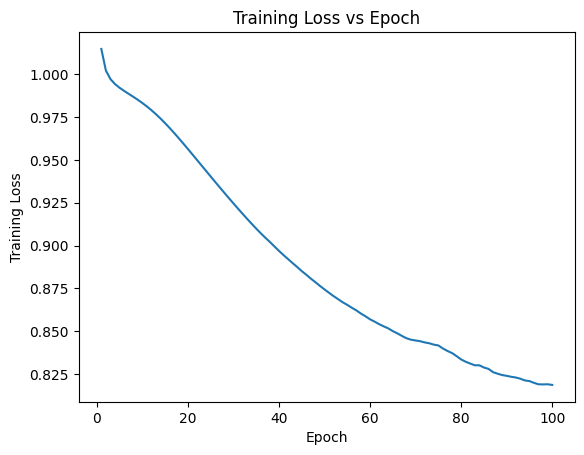

In [11]:
# Set the random seed for reproducibility
tf.random.set_seed(42)

# Define hyperparameters
batch_size = 32
timesteps = 10
input_dim = 20
hidden_units = 64
num_epochs = 100

# Generate training data
X_train, y_train = generate_data(1000, timesteps, input_dim)

# Create an instance of the LSTM model
model = LSTMModel(hidden_units, input_dim)

# Train the model
train_losses = train(model, X_train, y_train, num_epochs, batch_size)

# Plot training loss vs epoch
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch')
plt.show()